# EAS 503 - Final Project Code
## Predicting AirBnB Listing Price within New York City's Boroughs
### Group 7 | Gary Yu, Georgious Aland Feltama, Peter Pranata

#### Source: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

We start by importing all the requried packages. Please install them into your computer if it's not available. 

Packages used: ```sqlite3, pandas, numpy seaborn, matplotlib, sklearn, pprint```

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from pprint import pprint

%matplotlib inline

In [3]:
# Connect to SQL database
db = sqlite3.connect('airbnb.sql')
cursor = db.cursor()

In [4]:
# Execute query of selected data
cursor.execute('''SELECT neighbourhood_group, neighbourhood, room_type, price, minimum_nights, number_of_reviews,
               reviews_per_month, calculated_host_listings_count, availability_365 FROM airbnb;''')



In [5]:
# Get all the rows within the table and append it to a dataframe
records = cursor.fetchall()

df = []

for row in records:
    df.append(row)
header = ("Neighbourhood_Group", "Neighbourhood", "Room_Type", "Price", "Minimum_Night", "Number_of_Reviews",
          "Reviews_per_Month", "Host_Listing_Count", "Availability")
data = pd.DataFrame(df, columns = header)


In [6]:
# Convert object to specific data type for each column
data['Neighbourhood_Group'] = data['Neighbourhood_Group'].astype('category')
data['Neighbourhood'] = data['Neighbourhood'].astype('category')
data['Room_Type'] = data['Room_Type'].astype('category')
data['Price'] = data['Price'].astype(int)
data['Minimum_Night'] = data['Minimum_Night'].astype(int)
data['Number_of_Reviews'] = data['Number_of_Reviews'].astype(int)

data['Reviews_per_Month'] = pd.to_numeric(data['Reviews_per_Month'], errors = 'coerce')
data['Reviews_per_Month'] = data['Reviews_per_Month'].astype(float)

data['Host_Listing_Count'] = data['Host_Listing_Count'].astype(int)
data['Availability'] = data['Availability'].astype(int)


In [7]:
data.head()

,Neighbourhood_Group,Neighbourhood,Room_Type,Price,Minimum_Night,Number_of_Reviews,Reviews_per_Month,Host_Listing_Count,Availability
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


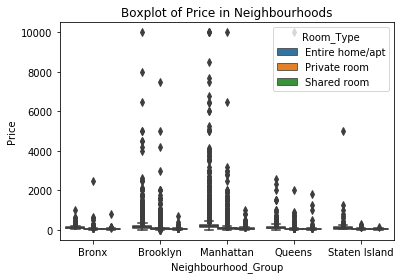

In [8]:
# Graph some basic charts
boxplots = sns.boxplot(x = "Neighbourhood_Group", y = "Price", hue = "Room_Type", data = data).set_title("Boxplot of Price in Neighbourhoods")


Looking at the boxplot, it is obvious that there are some extreme outliers present in our data. This may relate to luxury homes or apartments for rent. To narrow it down even further, we'll take a look at the mean price of each neighbourhood

Text(0.5, 1.0, 'Average Rent Price')

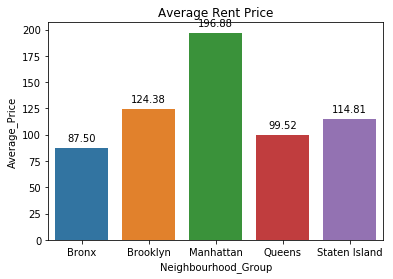

In [9]:
bronx_mean = data[data['Neighbourhood_Group'] == 'Bronx']['Price'].mean()
brooklyn_mean = data[data['Neighbourhood_Group'] == 'Brooklyn']['Price'].mean()
manhattan_mean = data[data['Neighbourhood_Group'] == 'Manhattan']['Price'].mean()
queens_mean = data[data['Neighbourhood_Group'] == 'Queens']['Price'].mean()
staten_mean = data[data['Neighbourhood_Group'] == 'Staten Island']['Price'].mean()

# Make plot of the means for easy comprehension
n_means = [['Bronx', bronx_mean], ['Brooklyn', brooklyn_mean], ['Manhattan', manhattan_mean], ['Queens', queens_mean], 
           ['Staten Island', staten_mean]]
means = pd.DataFrame(n_means, columns = ['Neighbourhood_Group', 'Average_Price'])

avg_price = sns.barplot(x = 'Neighbourhood_Group', y = 'Average_Price', data = means)
for p in avg_price.patches:
    avg_price.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Average Rent Price")

As you can see, the average rent price is very small compared to what the range is based on the boxplot. With that in mind, we will discard the last 1% of data by only using the 99th percentile of each neighbourhood group.

We will also remove any rows containing 0 to discard systematic error.

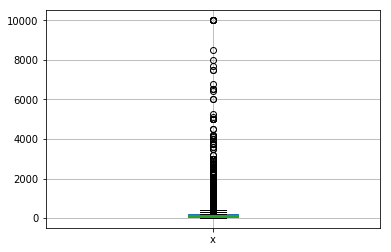

In [10]:
data = data[data.Price != 0]

# The code below will give us the upper whisker for each neighbourhood group, which will be used later on
_, bronx = pd.DataFrame.boxplot(data[data['Neighbourhood_Group'] == 'Bronx']['Price'], return_type='both')
bronx_uw = [whiskers.get_ydata() for whiskers in bronx["whiskers"]][1][1]

_, brooklyn = pd.DataFrame.boxplot(data[data['Neighbourhood_Group'] == 'Brooklyn']['Price'], return_type='both')
brooklyn_uw = [whiskers.get_ydata() for whiskers in brooklyn["whiskers"]][1][1]

_, manhattan = pd.DataFrame.boxplot(data[data['Neighbourhood_Group'] == 'Manhattan']['Price'], return_type='both')
manhattan_uw = [whiskers.get_ydata() for whiskers in manhattan["whiskers"]][1][1]

_, queens = pd.DataFrame.boxplot(data[data['Neighbourhood_Group'] == 'Queens']['Price'], return_type='both')
queens_uw = [whiskers.get_ydata() for whiskers in queens["whiskers"]][1][1]

_, staten = pd.DataFrame.boxplot(data[data['Neighbourhood_Group'] == 'Staten Island']['Price'], return_type='both')
staten_uw = [whiskers.get_ydata() for whiskers in staten["whiskers"]][1][1]

In [11]:
# Now that we have the upper whisker for each neighbourhood group, we will extract the rows to exclude outliers

d1 = data[(data['Neighbourhood_Group'] == 'Bronx') & (data['Price'] <= bronx_uw)]
d2 = data[(data['Neighbourhood_Group'] == 'Brooklyn') & (data['Price'] <= brooklyn_uw)]
d3 = data[(data['Neighbourhood_Group'] == 'Manhattan') & (data['Price'] <= manhattan_uw)]
d4 = data[(data['Neighbourhood_Group'] == 'Queens') & (data['Price'] <= queens_uw)]
d5 = data[(data['Neighbourhood_Group'] == 'Staten Island') & (data['Price'] <= staten_uw)]

clean_df = pd.concat([d1,d2,d3,d4,d5], ignore_index = True)


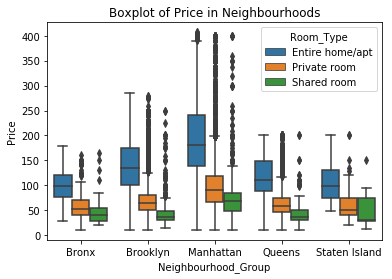

In [12]:
boxplots = sns.boxplot(x = "Neighbourhood_Group", y = "Price", hue = "Room_Type", data = clean_df).set_title("Boxplot of Price in Neighbourhoods")


Text(0.5, 1.0, 'Overall NYC Airbnb Price Distribution')

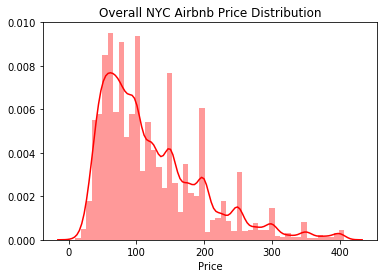

In [13]:
# Distribution of price in dataframe
sns.distplot(clean_df['Price'], color = 'red')
plt.title('Overall NYC Airbnb Price Distribution')


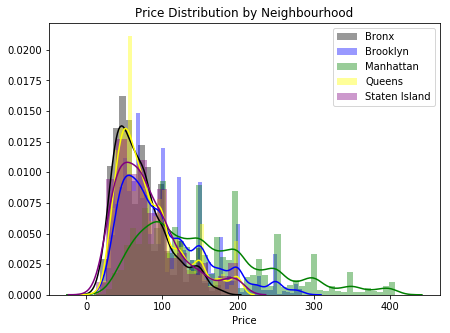

In [14]:
# Distribution of Price by Neighbourhood
plt.figure(figsize=(7,5))
sns.distplot(clean_df[clean_df['Neighbourhood_Group'] == 'Bronx']['Price'], color = 'black')
sns.distplot(clean_df[clean_df['Neighbourhood_Group'] == 'Brooklyn']['Price'], color = 'blue')
sns.distplot(clean_df[clean_df['Neighbourhood_Group'] == 'Manhattan']['Price'], color = 'green')
sns.distplot(clean_df[clean_df['Neighbourhood_Group'] == 'Queens']['Price'], color = 'yellow')
sns.distplot(clean_df[clean_df['Neighbourhood_Group'] == 'Staten Island']['Price'], color = 'purple')
plt.title('Price Distribution by Neighbourhood')
plt.legend(labels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])


Text(0.5, 1.0, 'Average Rent Price')

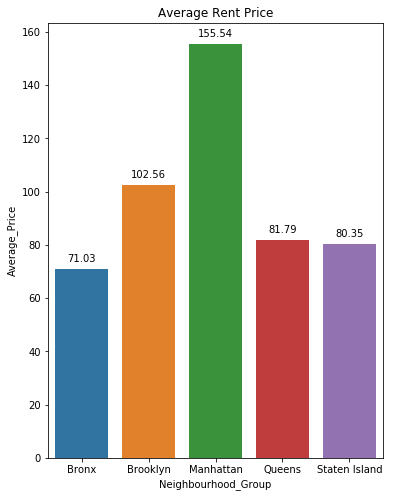

In [15]:
# Means AFTER removing outliers

bronx_mean = clean_df[clean_df['Neighbourhood_Group'] == 'Bronx']['Price'].mean()
brooklyn_mean = clean_df[clean_df['Neighbourhood_Group'] == 'Brooklyn']['Price'].mean()
manhattan_mean = clean_df[clean_df['Neighbourhood_Group'] == 'Manhattan']['Price'].mean()
queens_mean = clean_df[clean_df['Neighbourhood_Group'] == 'Queens']['Price'].mean()
staten_mean = clean_df[clean_df['Neighbourhood_Group'] == 'Staten Island']['Price'].mean()

n_means = [['Bronx', bronx_mean], ['Brooklyn', brooklyn_mean], ['Manhattan', manhattan_mean], ['Queens', queens_mean], 
           ['Staten Island', staten_mean]]
means = pd.DataFrame(n_means, columns = ['Neighbourhood_Group', 'Average_Price'])

plt.figure(figsize = (6,8))
avg_price = sns.barplot(x = 'Neighbourhood_Group', y = 'Average_Price', data = means)
for p in avg_price.patches:
    avg_price.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title("Average Rent Price")



In [16]:
# Replaces any NAs in 'Reviews_per_Month' with 0 -> No reviews has a negative connotone so we'll give it a negative effect
clean_df.fillna({'Reviews_per_Month':0}, inplace=True)

## Model Fit & Validation
### Source: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

Based on the roadmap provided by towardsdatascience.com, we went ahead with regression (lasso & ridge) models and will see if it's decent in terms of fit. If it's not really good, we'll move on and try out ensemble regressor methods such as random forest.

In [17]:
# Initialize training-testing set and convert categorical variables using one-hot encoding

var = ("Neighbourhood_Group", "Room_Type", "Minimum_Night", "Number_of_Reviews",
          "Reviews_per_Month", "Host_Listing_Count", "Availability")

# We only use a very small fraction of the sample because running our random forest were causing an issue with such a large
# sample size, especially when we hypertune the parameters
sdf = clean_df.sample(frac = 0.1, random_state = 10)
sdf.describe()

sdf = sdf.drop(columns = "Neighbourhood")
sdf = sdf[sdf.Price != 0]

# One-hot encoding for the neighbourhood group AND room type
sdf = pd.get_dummies(sdf)
sdf.iloc[:,5:].head(5)

finaldf = sdf

y = np.array(finaldf["Price"])

# Remove y(response) from the finaldf
finaldf = finaldf.drop(columns = "Price")

var_names = list(finaldf.columns)

# Convert to numpy array
finaldf = np.array(finaldf)

from sklearn.model_selection import train_test_split

# Split data to training and testing set
train_x, test_x, train_y, test_y = train_test_split(finaldf, y, test_size = 0.25, random_state = 10)


In [18]:
# Function to easily calculate the errors and find the prediction accuracy and make abline
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return [accuracy, r2_score(test_labels, predictions)]
    
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'red')

### Linear Regression

In [19]:
# Import LR package from sklearn
from sklearn.linear_model import LinearRegression

In [20]:
# Fit model using training set
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
# Predict using testing set
lr_pred = lr.predict(test_x)
train_score = lr.score(train_x, train_y)
test_score = lr.score(test_x, test_y)

Text(0, 0.5, 'Predicted')

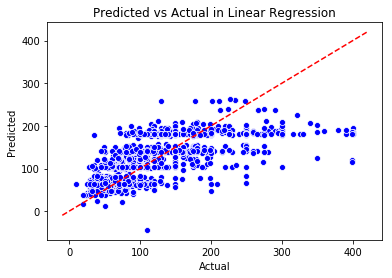

In [22]:
lr_plot = sns.scatterplot(x = test_y, y = lr_pred, color = 'b').set_title("Predicted vs Actual in Linear Regression"); abline(1,0)
plt.xlabel("Actual")
plt.ylabel("Predicted")

Looking at the Predicted vs Actual graph, we can see that there are some data that is not being fitted well.

### Ridge Regression

In [23]:
# Import package for ridge regression
from sklearn.linear_model import Ridge

In [24]:
# We will try two types of ridge regression: one with alpha = 0.01, and the other one with alpha = 100
rr = Ridge(alpha = 0.01)
rr.fit(train_x, train_y)

rr100 = Ridge(alpha = 100)
rr100.fit(train_x, train_y)


Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [25]:
rr_train_score = rr.score(train_x, train_y)
rr_test_score = rr.score(test_x, test_y)

rr100_train_score = rr100.score(train_x, train_y)
rr100_test_score = rr100.score(test_x, test_y)

In [26]:
# Predict values of ridge regression
rr_pred = rr.predict(test_x)
rr100_pred = rr100.predict(test_x)

Text(0, 0.5, 'Predicted')

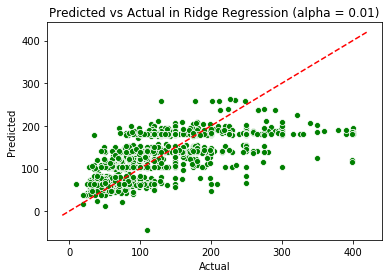

In [27]:
# Graph ridge regression performance for alpha = 0.01
rr_plot = sns.scatterplot(x = test_y, y = rr_pred, color = 'g').set_title("Predicted vs Actual in Ridge Regression (alpha = 0.01)"); abline(1,0)
plt.xlabel("Actual")
plt.ylabel("Predicted")


Text(0, 0.5, 'Predicted')

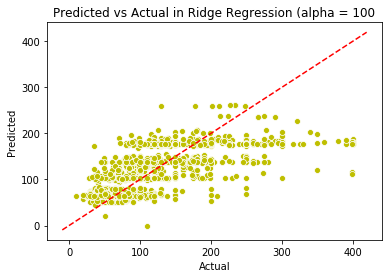

In [28]:
# Graph for alpha = 100
rr100_plot = sns.scatterplot(x = test_y, y = rr100_pred, color = 'y').set_title("Predicted vs Actual in Ridge Regression (alpha = 100"); abline(1,0)
plt.xlabel("Actual")
plt.ylabel("Predicted")

### Lasso Regression

In [29]:
# Import package for lasso regression
from sklearn.linear_model import Lasso

In [30]:
# Train model and check score
lasso = Lasso(alpha = 0.1)
lasso.fit(train_x, train_y)
lasso_train_score = lasso.score(train_x, train_y)
lasso_test_score = lasso.score(test_x, test_y)

In [31]:
# Predict the response using the fitted model on the test data
lasso_pred = lasso.predict(test_x)

Text(0, 0.5, 'Predicted')

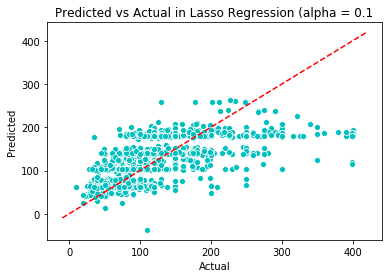

In [32]:
# Plot of the actual vs predicted in lasso regression
lasso_plot = sns.scatterplot(x = test_y, y = lasso_pred, color = 'c').set_title("Predicted vs Actual in Lasso Regression (alpha = 0.1"); abline(1,0)
plt.xlabel("Actual")
plt.ylabel("Predicted")

#### Now that we ran all the models for regression, we will compare the performance with one another

In [33]:
lr_r = evaluate(lr, test_x, test_y)
rr_r = evaluate(rr, test_x, test_y)
rr100_r = evaluate(rr100, test_x, test_y)
lasso_r = evaluate(lasso, test_x, test_y)

Model Performance
Average Error: 38.6454 degrees.
Accuracy = 63.25%.
Model Performance
Average Error: 38.6454 degrees.
Accuracy = 63.25%.
Model Performance
Average Error: 38.9073 degrees.
Accuracy = 62.17%.
Model Performance
Average Error: 38.6598 degrees.
Accuracy = 63.20%.


Text(0, 0.5, 'Accuracy (100 - MAPE)')

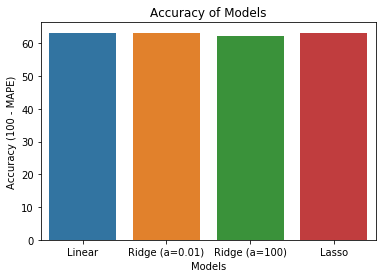

In [34]:
# Visualize the results into a table and make it into a graph
models = ['Linear', 'Ridge (a=0.01)', 'Ridge (a=100)', 'Lasso']
model_selection = pd.DataFrame([lr_r, rr_r, rr100_r, lasso_r], index = models, columns = ['Accuracy', 'R-sq'])

sns.barplot(x = model_selection.index.values, y = model_selection['Accuracy']).set_title("Accuracy of Models")
plt.xlabel("Models")
plt.ylabel("Accuracy (100 - MAPE)")

Text(0, 0.5, 'R-square')

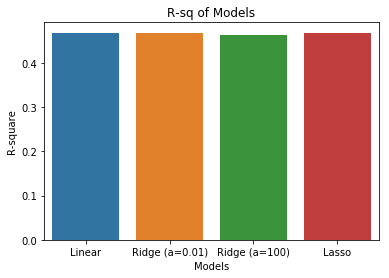

In [35]:
sns.barplot(x = model_selection.index.values, y = model_selection['R-sq']).set_title("R-sq of Models")
plt.xlabel("Models")
plt.ylabel("R-square")

As you can see, there is almost no difference in using any of the regression model; they all performed very similarly and decently. 

Since the performance is not exactly outstanding, we will try out other methods as suggested by the roadmap. As decided early on, we will try to fit our data set and train it using an ensemble regressor model.

Ensemble regressor models are basically bagged decision trees that is iterated over and over again using a boostrapped data. To ensure that there is no correlation between the variables when building the tree, we will utilize a random forest model.

## Ensemble Regressor Methods
### Random Forest

In [36]:
# Import model from sklearn
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Make model with 1000 decision trees (standard)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 10)

# Train model on training set
rf.fit(train_x, train_y)

# Prediction test data
predictions = rf.predict(test_x)


In [38]:
# Basic analysis on the performance of the initial random forest model
# Calculate the absolute errors
errors = abs(predictions - test_y)

print("Mean Absolute Error: ", round(np.mean(errors),2), 'degrees.')

mape = 100 * (errors / test_y)

accuracy = 100 - np.mean(mape)
print("Accuracy: ", round(accuracy, 2), "%.")
# Accuracy isn't too good, only around 63.04% (with 42k data, it was 62.45% so not too big of a difference)


Mean Absolute Error:  38.94 degrees.
Accuracy:  63.04 %.


Looking at the errors, it's very decent and similar to the regression models. Because of that, we'll see what we can do to improve the accuracy.

We'll start by checking if any variable is significantly more important than other.

Variable: Room_Type_Entire home/apt Importance: 0.36 
Variable: Reviews_per_Month    Importance: 0.13 
Variable: Availability         Importance: 0.13 
Variable: Neighbourhood_Group_Manhattan Importance: 0.11 
Variable: Number_of_Reviews    Importance: 0.1 
Variable: Minimum_Night        Importance: 0.09 
Variable: Host_Listing_Count   Importance: 0.06 
Variable: Neighbourhood_Group_Brooklyn Importance: 0.01 
Variable: Neighbourhood_Group_Bronx Importance: 0.0 
Variable: Neighbourhood_Group_Queens Importance: 0.0 
Variable: Neighbourhood_Group_Staten Island Importance: 0.0 
Variable: Room_Type_Private room Importance: 0.0 
Variable: Room_Type_Shared room Importance: 0.0 


Text(0.5, 1.0, 'Cumulative Importances')

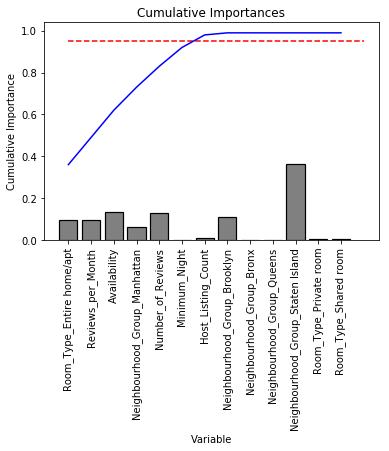

In [39]:
# Feature Importance Analysis
# Will check variable importance next:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(var_names, importances)]

# Sort the features based on the ones most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

# Plot the importances
x_values = list(range(len(importances)))

#import rhinoscriptsyntax as rs
#acolor = rs.CreateColor(240, 128, 128)
plt.bar(x_values, importances, orientation = 'vertical', color = 'grey', edgecolor = 'black', linewidth = 1.2)
plt.xticks(x_values, var_names, rotation = 'vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

# Make pareto chart of importance
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances)
                                
plt.plot(x_values, cumulative_importances, 'b-')
plt.hlines(y = 0.95, xmin = 0, xmax = len(sorted_importances), color = 'r', linestyle = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
    

Looking at our cumulative importance graph, we can see that there is no exactly one type of variable or features that is affecting the error. We see that being in staten island affects the response the most but it is also relatively decent and not too significant. Because of this, we will try to hypertune our parameters instead to increase the performance.

### Hyperparameter Tuning for Random Forest
#### Random Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV

In [41]:
# We start by using RandomizedSearchCV to narrow down the potential parameters
# Tune for number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to be considered at each split
max_features = ['auto', 'sqrt'] 
# Max levels in each tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Min number of samples required to split a node
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Method of selecting samples
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


We will now use the chosen parameters from our random search and apply it into the RF model:

In [43]:
# Re-run the model again using updated parameters
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state= 10, n_jobs = -1)

# Fit the model
rf_random.fit(train_x, train_y)
rf_random.best_params_

# Running this cell will take a while since we are building large trees with all the chosen parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [44]:
# Check the results of the updated RF model from the Random Search parameter
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_x, test_y)

Model Performance
Average Error: 36.5509 degrees.
Accuracy = 64.97%.


As you can see, our hyperparameter tuning worked and increased the model accuracy by a little. Now that we have this updated parameters, we can try and improve furthermore by using a Grid Search method as part of an extension in the hyperparameter tuning.

In [47]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [48]:
# Train the RF model using the grid search best parameters
grid_search.fit(train_x, train_y)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 232 out of 243 | elapsed:   13.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   13.9s finished


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [49]:
# Check if grid search improved the model
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_x, test_y)


Model Performance
Average Error: 36.5699 degrees.
Accuracy = 64.96%.


Looking at the results of Grid Search, it seems that the accuracy didn't change much; in fact, it was reduced by 0.01% but this is probably due to the randomness that exist. 

### Visualization for Random Forest

In [50]:
from sklearn.tree import export_graphviz
import pydot

In [51]:
tree = best_grid.estimators_[5]

In [66]:
# This code below will create the tree and save the image as a .png
# Image will be stored in the working directory if this notebook file
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = var_names, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

Looking at the generated tree image, it is very hard to comprehend due to the depth of it. We went ahead and tried to limit the depth to only 3 to make it more interpretable.

In [55]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_x, train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]

In [56]:
# Check fit and accuracy of small tree
rf_small_result = evaluate(tree_small, test_x, test_y)


Model Performance
Average Error: 37.5438 degrees.
Accuracy = 64.85%.


This is pretty surprising. Even though we reduced the depth to only 3, the model accuracy was not reduced by too much. It's actually a pretty good fit considering that the model is now way more interpretable and easier to follow.

In [67]:
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = var_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

As you can see, the small_tree is much easier to comprehend while giving us a pretty good accuracy fit.

Text(0, 0.5, 'Predicted')

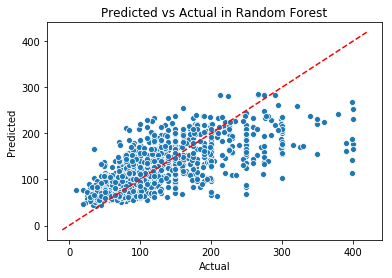

In [71]:
# Predict on test data for best model
predictions = best_grid.predict(test_x)

# Plot Actual vs Predicted
rf_plot = sns.scatterplot(x = test_y, y = predictions, palette = "pastel").set_title("Predicted vs Actual in Random Forest"); abline(1,0)
plt.xlabel("Actual")
plt.ylabel("Predicted")

The graph above shows the performance of fitted vs actual values of our tuned random forest model. It is very similar to what we had in our regression model but it is a little bit more accurate than them.

## Model Comparison and Final Model Selection

In [75]:
lr_r = evaluate(lr, test_x, test_y)
rr_r = evaluate(rr, test_x, test_y)
rr100_r = evaluate(rr100, test_x, test_y)
lasso_r = evaluate(lasso, test_x, test_y)
rf_r = evaluate(best_grid, test_x, test_y)

Model Performance
Average Error: 38.6454 degrees.
Accuracy = 63.25%.
Model Performance
Average Error: 38.6454 degrees.
Accuracy = 63.25%.
Model Performance
Average Error: 38.9073 degrees.
Accuracy = 62.17%.
Model Performance
Average Error: 38.6598 degrees.
Accuracy = 63.20%.
Model Performance
Average Error: 36.5699 degrees.
Accuracy = 64.96%.


In [76]:
models = ['Linear', 'Ridge (a=0.01)', 'Ridge (a=100)', 'Lasso', 'Random Forest']
model_selection = pd.DataFrame([lr_r, rr_r, rr100_r, lasso_r, rf_r], index = models, columns = ['Accuracy', 'R-sq'])

Text(0, 0.5, 'Accuracy (100 - MAPE)')

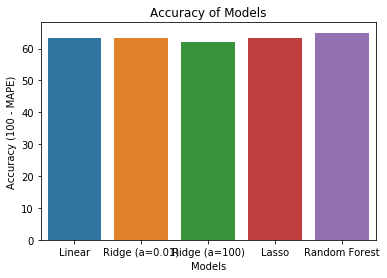

In [77]:
sns.barplot(x = model_selection.index.values, y = model_selection['Accuracy']).set_title("Accuracy of Models")
plt.xlabel("Models")
plt.ylabel("Accuracy (100 - MAPE)")

Text(0, 0.5, 'R-square')

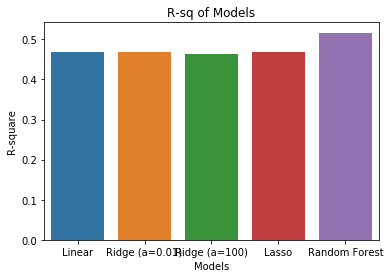

In [78]:
sns.barplot(x = model_selection.index.values, y = model_selection['R-sq']).set_title("R-sq of Models")
plt.xlabel("Models")
plt.ylabel("R-square")

Overall, we can conclude that although regression models like Ridge and Lasso performed pretty decent, Random Forest, in general, has a better fit for predicting the price of AirBnb in New York City's Boroughs. Despite the improvement from hypertuning the random forest model, we saw that there was not a significant increase in model accuracy and having too deep of a tree also didn't help the cause. In fact, using only a depth of 3 allowed us to generate a much more interpretable model with only a reduction of less than 0.1%. Due to this, we might use a smaller random forest model to cut down the processing time and increase interpretability.

#### Several conclusions from our model:

More features should be added to increase model accuracy. Unfortunately, the dataset that we have mostly contains features like reviews. An interesting future approach would be to compare it with other potential external factors such as seasons within the year and other. 

As of for now, our model concludes that room type has the highest impact in determing the prices; which makes sense. 

This also tells us that host doesn't necessarily increase their price based on higher reviews; they are inelastic to the number of reviews. 

##### From our model, we can utilize the information to provide pricing suggestions for their customers and business partners. Given the basic features of a listing, people can use the model to predict future outcome and success of it.